In [217]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

def reverseBits(num, bit_count):
    reverse_num = tf.zeros([], tf.int32)
    def loop_body(i):
        tf.if_cond((num & (1 << i)) != 0, lambda: reverse_num.set(reverse_num | (1 << ((bit_count - 1) - i))))
    tf.loop(loop_body,  0, bit_count, 1)
    return reverse_num + ((num >> bit_count) << bit_count)

def getIndexPair(i, it):
    k1 = reverseBits(2*i, it+1)
    k2 = k1 + (1 << it)
    return [k1, k2]

#in-place FFT implementation
def FFT():
    Signal = tf.input([-1], tf.float32)
    N = Signal.shape[0]
    
    it_num = tf.int(tf.floor(tf.log2(tf.float(N))))-1
    Re = tf.buffer([N], tf.float32)
    Im = tf.buffer([N], tf.float32)

    i, = tf.indices([N/2])
    
    k1, k2 = getIndexPair(i, it_num)
    S1 = Signal[k1]
    S2 = Signal[k2]
    Re[2*i] = S1 + S2
    Im[2*i] = 0.0
    Re[2*i+1] = S1 - S2
    Im[2*i+1] = 0.0
    
    def fft_iteration(it):
        k1, k2 = getIndexPair(i, it)
        k3 = (k1 & ((1 << it) - 1)) * (1 << (it_num - it))
        alpha = 2 * np.pi * tf.float(k3) / tf.float(N)
        Re1 = Re[k2]
        Im1 = Im[k2]
        Re2 = Re[k1]
        Im2 = Im[k1]
        C = tf.cos(alpha)
        S = tf.sin(alpha)
        m = C * Re1 + S * Im1
        n = -S * Re1 + C * Im1
        Re[k1] = Re2 + m
        Im[k1] = Im2 + n
        Re[k2] = Re2 - m
        Im[k2] = Im2 - n

    tf.loop(fft_iteration, 1, it_num+1, 1)

    return [Re, Im]

fft = tf.compile(FFT)

FFT:
  Kernel count: 2
  Intermediate buffers: 0
  Lines of generated code: 427



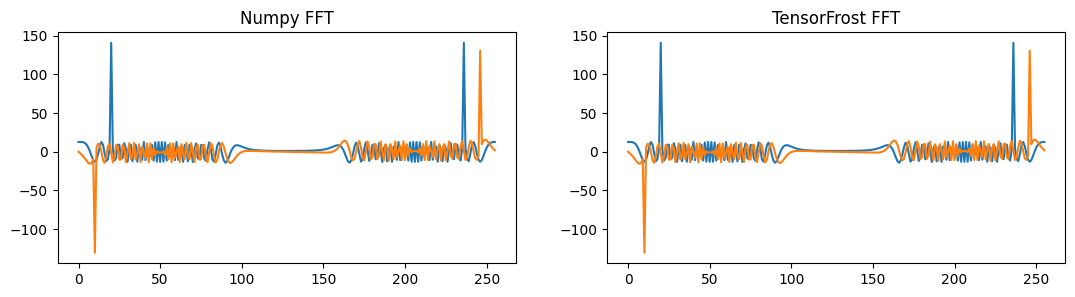

In [218]:
#test signal
N = 256
t = np.arange(N)
signal = np.sin(10 * 2 * np.pi * t / N).astype(np.float32)
signal += np.cos(20 * 2 * np.pi * t / N)
signal += np.sin(50 * 2 * np.pi * t * t / (N * N) + np.pi/4)

#run the FFT
signal_tf = tf.tensor(signal)
Re_tf, Im_tf = fft(signal_tf)
Re = Re_tf.numpy
Im = Im_tf.numpy

#compare with numpy
np_fft = np.fft.fft(signal)

#plot the results side by side
plt.figure(figsize=(13, 3))
plt.subplot(1, 2, 1)
plt.plot(np.real(np_fft), label="Real")
plt.plot(np.imag(np_fft), label="Imaginary")
plt.title("Numpy FFT")
plt.subplot(1, 2, 2)
plt.plot(Re, label="Real")
plt.plot(Im, label="Imaginary")
plt.title("TensorFrost FFT")

plt.show()